In [67]:
import pandas as pd
import numpy as np
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score

import xgboost as xgb
from xgboost import plot_importance

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
train_df = pd.read_csv('data/train.csv', parse_dates=['first_active_month'])
test_df = pd.read_csv('data/test.csv', parse_dates=['first_active_month'])

In [3]:
def data_show(data):
    display(data.head(5))
    display(data.info())
    print('shape:', data.shape)

In [4]:
data_show(train_df)

,first_active_month,card_id,feature_1,feature_2,feature_3,target
0,2017-06-01,C_ID_92a2005557,5,2,1,-0.820283
1,2017-01-01,C_ID_3d0044924f,4,1,0,0.392913
2,2016-08-01,C_ID_d639edf6cd,2,2,0,0.688056
3,2017-09-01,C_ID_186d6a6901,4,3,0,0.142495
4,2017-11-01,C_ID_cdbd2c0db2,1,3,0,-0.159749


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 201917 entries, 0 to 201916
Data columns (total 6 columns):
first_active_month    201917 non-null datetime64[ns]
card_id               201917 non-null object
feature_1             201917 non-null int64
feature_2             201917 non-null int64
feature_3             201917 non-null int64
target                201917 non-null float64
dtypes: datetime64[ns](1), float64(1), int64(3), object(1)
memory usage: 9.2+ MB


None

shape: (201917, 6)


/Users/aleksandrbojko/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


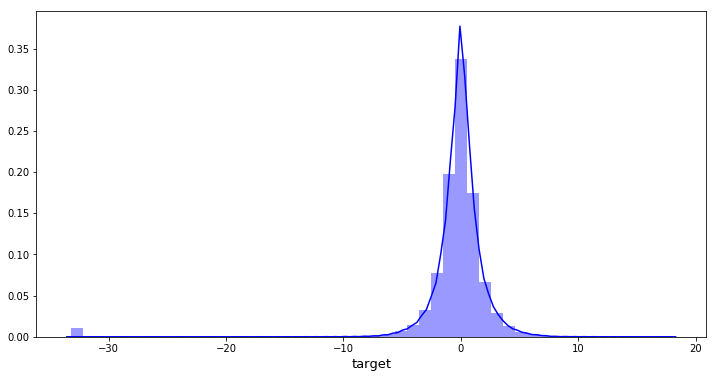

In [5]:
plt.figure(figsize=(12, 6))
sns.distplot(train_df['target'], bins=50, color='blue')
plt.xlabel('target', fontsize=13)
plt.show()

In [6]:
[print(train_df['feature_' + str(i)].value_counts()) for i in np.arange(1, 4)]

3    73573
2    55797
5    40625
4    19885
1    12037
Name: feature_1, dtype: int64
1    89242
2    74839
3    37836
Name: feature_2, dtype: int64
1    114198
0     87719
Name: feature_3, dtype: int64


[None, None, None]

In [7]:
hist_df = pd.read_csv('data/historical_transactions.csv')

In [8]:
data_show(hist_df)

,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id
0,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_e020e9b302,-8,-0.703331,2017-06-25 15:33:07,1.0,16,37
1,Y,C_ID_4e6213e9bc,88,N,0,A,367,M_ID_86ec983688,-7,-0.733128,2017-07-15 12:10:45,1.0,16,16
2,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_979ed661fc,-6,-0.720386,2017-08-09 22:04:29,1.0,16,37
3,Y,C_ID_4e6213e9bc,88,N,0,A,560,M_ID_e6d5ae8ea6,-5,-0.735352,2017-09-02 10:06:26,1.0,16,34
4,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_e020e9b302,-11,-0.722865,2017-03-10 01:14:19,1.0,16,37


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29112361 entries, 0 to 29112360
Data columns (total 14 columns):
authorized_flag         object
card_id                 object
city_id                 int64
category_1              object
installments            int64
category_3              object
merchant_category_id    int64
merchant_id             object
month_lag               int64
purchase_amount         float64
purchase_date           object
category_2              float64
state_id                int64
subsector_id            int64
dtypes: float64(2), int64(6), object(6)
memory usage: 3.0+ GB


None

shape: (29112361, 14)


In [9]:
gdf = hist_df.groupby("card_id")
gdf = gdf["purchase_amount"].size().reset_index()
gdf.columns = ['card_id', 'num_hist_transaction']
train_df = pd.merge(train_df, gdf, on='card_id', how='left')
test_df = pd.merge(test_df, gdf, on='card_id', how='left')

In [10]:
data_show(train_df)

,first_active_month,card_id,feature_1,feature_2,feature_3,target,num_hist_transaction
0,2017-06-01,C_ID_92a2005557,5,2,1,-0.820283,260
1,2017-01-01,C_ID_3d0044924f,4,1,0,0.392913,350
2,2016-08-01,C_ID_d639edf6cd,2,2,0,0.688056,43
3,2017-09-01,C_ID_186d6a6901,4,3,0,0.142495,77
4,2017-11-01,C_ID_cdbd2c0db2,1,3,0,-0.159749,133


<class 'pandas.core.frame.DataFrame'>
Int64Index: 201917 entries, 0 to 201916
Data columns (total 7 columns):
first_active_month      201917 non-null datetime64[ns]
card_id                 201917 non-null object
feature_1               201917 non-null int64
feature_2               201917 non-null int64
feature_3               201917 non-null int64
target                  201917 non-null float64
num_hist_transaction    201917 non-null int64
dtypes: datetime64[ns](1), float64(1), int64(4), object(1)
memory usage: 12.3+ MB


None

shape: (201917, 7)


In [11]:
cnt_srs = train_df.groupby("num_hist_transaction")['target'].mean()
cnt_srs = cnt_srs.sort_index()
cnt_srs = cnt_srs[:-50]

In [12]:
bins = [0, 10, 20, 30, 40, 50, 75, 100, 150, 200, 500, 10000]
train_df['binned_num_hist_transactions'] = pd.cut(train_df['num_hist_transaction'], bins)

In [13]:
cnt_srs = train_df.groupby("binned_num_hist_transactions")['target'].mean()

In [14]:
gdf = hist_df.groupby('card_id')['purchase_amount'].agg(['sum', 'mean', 'std', 'min', 'max']).reset_index()
gdf.columns = ["card_id", "sum_hist_trans", "mean_hist_trans", "std_hist_trans",
               "min_hist_trans", "max_hist_trans"]

In [15]:
train_df = pd.merge(train_df, gdf, on="card_id", how="left")
test_df = pd.merge(test_df, gdf, on="card_id", how="left")

In [16]:
data_show(train_df)

,first_active_month,card_id,feature_1,feature_2,feature_3,target,num_hist_transaction,binned_num_hist_transactions,sum_hist_trans,mean_hist_trans,std_hist_trans,min_hist_trans,max_hist_trans
0,2017-06-01,C_ID_92a2005557,5,2,1,-0.820283,260,"(200, 500]",-165.968739,-0.638341,0.212139,-0.739395,2.258395
1,2017-01-01,C_ID_3d0044924f,4,1,0,0.392913,350,"(200, 500]",-210.006336,-0.600018,0.384967,-0.742400,4.630299
2,2016-08-01,C_ID_d639edf6cd,2,2,0,0.688056,43,"(40, 50]",-29.167391,-0.678311,0.087380,-0.730138,-0.145847
3,2017-09-01,C_ID_186d6a6901,4,3,0,0.142495,77,"(75, 100]",-49.491364,-0.642745,0.261624,-0.740897,1.445596
4,2017-11-01,C_ID_cdbd2c0db2,1,3,0,-0.159749,133,"(100, 150]",-48.687656,-0.366073,1.352094,-0.746156,7.193041


<class 'pandas.core.frame.DataFrame'>
Int64Index: 201917 entries, 0 to 201916
Data columns (total 13 columns):
first_active_month              201917 non-null datetime64[ns]
card_id                         201917 non-null object
feature_1                       201917 non-null int64
feature_2                       201917 non-null int64
feature_3                       201917 non-null int64
target                          201917 non-null float64
num_hist_transaction            201917 non-null int64
binned_num_hist_transactions    201917 non-null category
sum_hist_trans                  201917 non-null float64
mean_hist_trans                 201917 non-null float64
std_hist_trans                  201917 non-null float64
min_hist_trans                  201917 non-null float64
max_hist_trans                  201917 non-null float64
dtypes: category(1), datetime64[ns](1), float64(6), int64(4), object(1)
memory usage: 20.2+ MB


None

shape: (201917, 13)


In [17]:
bins = np.percentile(train_df["sum_hist_trans"], range(0,101,10))
train_df['binned_sum_hist_trans'] = pd.cut(train_df['sum_hist_trans'], bins)

In [18]:
new_trans_df = pd.read_csv('data/new_merchant_transactions.csv')
data_show(new_trans_df)

,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id
0,Y,C_ID_415bb3a509,107,N,1,B,307,M_ID_b0c793002c,1,-0.557574,2018-03-11 14:57:36,1.0,9,19
1,Y,C_ID_415bb3a509,140,N,1,B,307,M_ID_88920c89e8,1,-0.569580,2018-03-19 18:53:37,1.0,9,19
2,Y,C_ID_415bb3a509,330,N,1,B,507,M_ID_ad5237ef6b,2,-0.551037,2018-04-26 14:08:44,1.0,9,14
3,Y,C_ID_415bb3a509,-1,Y,1,B,661,M_ID_9e84cda3b1,1,-0.671925,2018-03-07 09:43:21,NaN,-1,8
4,Y,C_ID_ef55cf8d4b,-1,Y,1,B,166,M_ID_3c86fa3831,1,-0.659904,2018-03-22 21:07:53,NaN,-1,29


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1963031 entries, 0 to 1963030
Data columns (total 14 columns):
authorized_flag         object
card_id                 object
city_id                 int64
category_1              object
installments            int64
category_3              object
merchant_category_id    int64
merchant_id             object
month_lag               int64
purchase_amount         float64
purchase_date           object
category_2              float64
state_id                int64
subsector_id            int64
dtypes: float64(2), int64(6), object(6)
memory usage: 209.7+ MB


None

shape: (1963031, 14)


In [19]:
gdf = new_trans_df.groupby('card_id')['purchase_amount'].size().reset_index()
gdf.columns = ['card_id', 'num_merch_transactions']

train_df = pd.merge(train_df, gdf, on='card_id', how='left')
test_df = pd.merge(test_df, gdf, on='card_id', how='left')

In [20]:
bins = [0, 10, 20, 30, 40, 50, 75, 10000]
train_df['binned_num_merch_transactions'] = pd.cut(train_df['num_merch_transactions'], bins)

In [21]:
gdf = new_trans_df.groupby('card_id')['purchase_amount'].agg(['sum', 'mean', 'std', 'min', 'max']).reset_index()
gdf.columns = ["card_id", "sum_merch_trans", "mean_merch_trans", "std_merch_trans", "min_merch_trans",
               "max_merch_trans"]

train_df = pd.merge(train_df, gdf, on='card_id', how='left')
test_df = pd.merge(test_df, gdf, on='card_id', how='left')

In [22]:
bins = np.nanpercentile(train_df["sum_merch_trans"], range(0,101,10))
train_df['binned_sum_merch_trans'] = pd.cut(train_df['sum_merch_trans'], bins)

In [23]:
bins = np.nanpercentile(train_df["mean_merch_trans"], range(0,101,10))
train_df['binned_mean_merch_trans'] = pd.cut(train_df['mean_merch_trans'], bins)

In [24]:
train_df.head(5)

,first_active_month,card_id,feature_1,feature_2,feature_3,target,num_hist_transaction,binned_num_hist_transactions,sum_hist_trans,mean_hist_trans,...,binned_sum_hist_trans,num_merch_transactions,binned_num_merch_transactions,sum_merch_trans,mean_merch_trans,std_merch_trans,min_merch_trans,max_merch_trans,binned_sum_merch_trans,binned_mean_merch_trans
0,2017-06-01,C_ID_92a2005557,5,2,1,-0.820283,260,"(200, 500]",-165.968739,-0.638341,...,"(-2088.013, -124.526]",23.0,"(20, 30]",-13.244202,-0.575835,0.135812,-0.724368,-0.296112,"(-70.813, -8.882]","(-0.61, -0.565]"
1,2017-01-01,C_ID_3d0044924f,4,1,0,0.392913,350,"(200, 500]",-210.006336,-0.600018,...,"(-2088.013, -124.526]",6.0,"(0, 10]",-4.355735,-0.725956,0.014326,-0.739410,-0.701858,"(-4.574, -3.483]","(-0.747, -0.717]"
2,2016-08-01,C_ID_d639edf6cd,2,2,0,0.688056,43,"(40, 50]",-29.167391,-0.678311,...,"(-30.387, -22.109]",1.0,"(0, 10]",-0.700326,-0.700326,NaN,-0.700326,-0.700326,"(-0.739, -0.578]","(-0.701, -0.684]"
3,2017-09-01,C_ID_186d6a6901,4,3,0,0.142495,77,"(75, 100]",-49.491364,-0.642745,...,"(-55.864, -41.057]",7.0,"(0, 10]",-4.654372,-0.664910,0.065882,-0.734135,-0.566740,"(-6.139, -4.574]","(-0.665, -0.642]"
4,2017-11-01,C_ID_cdbd2c0db2,1,3,0,-0.159749,133,"(100, 150]",-48.687656,-0.366073,...,"(-55.864, -41.057]",36.0,"(30, 40]",-19.926237,-0.553507,0.223821,-0.739395,0.450886,"(-70.813, -8.882]","(-0.565, -0.487]"


In [25]:
train_df['year'] = train_df['first_active_month'].dt.year
test_df["year"] = test_df["first_active_month"].dt.year
train_df["month"] = train_df["first_active_month"].dt.month
test_df["month"] = test_df["first_active_month"].dt.month

In [26]:
cols_to_use = [
               "feature_1", "feature_2", "feature_3", "year", "month", 
               "num_hist_transaction", "sum_hist_trans", "mean_hist_trans", "std_hist_trans", 
               "min_hist_trans", "max_hist_trans",
               "num_merch_transactions", "sum_merch_trans", "mean_merch_trans", "std_merch_trans",
               "min_merch_trans", "max_merch_trans"
]

In [27]:
data_show(test_df[cols_to_use])

,feature_1,feature_2,feature_3,year,month,num_hist_transaction,sum_hist_trans,mean_hist_trans,std_hist_trans,min_hist_trans,max_hist_trans,num_merch_transactions,sum_merch_trans,mean_merch_trans,std_merch_trans,min_merch_trans,max_merch_trans
0,3,3,1,2017.0,4.0,68,-40.733733,-0.599025,0.192268,-0.743902,0.235676,3.0,-1.777156,-0.592385,0.182843,-0.722114,-0.383266
1,2,3,0,2017.0,1.0,78,-49.136513,-0.629955,0.154999,-0.731881,0.318817,9.0,-5.944698,-0.660522,0.071147,-0.740897,-0.506484
2,5,1,1,2017.0,8.0,13,4.528840,0.348372,0.906547,-0.536537,2.525866,2.0,0.180138,0.090069,1.151788,-0.724368,0.904506
3,2,1,0,2017.0,12.0,26,-13.690715,-0.526566,0.219162,-0.731881,0.087965,10.0,-5.743674,-0.574367,0.073166,-0.671775,-0.447880
4,5,1,1,2015.0,12.0,110,25.139384,0.228540,2.777764,-0.746758,15.782255,6.0,12.064997,2.010833,6.028671,-0.704082,14.279604


<class 'pandas.core.frame.DataFrame'>
Int64Index: 123623 entries, 0 to 123622
Data columns (total 17 columns):
feature_1                 123623 non-null int64
feature_2                 123623 non-null int64
feature_3                 123623 non-null int64
year                      123622 non-null float64
month                     123622 non-null float64
num_hist_transaction      123623 non-null int64
sum_hist_trans            123623 non-null float64
mean_hist_trans           123623 non-null float64
std_hist_trans            123623 non-null float64
min_hist_trans            123623 non-null float64
max_hist_trans            123623 non-null float64
num_merch_transactions    110015 non-null float64
sum_merch_trans           110015 non-null float64
mean_merch_trans          110015 non-null float64
std_merch_trans           93792 non-null float64
min_merch_trans           110015 non-null float64
max_merch_trans           110015 non-null float64
dtypes: float64(13), int64(4)
memory usage: 17.0

None

shape: (123623, 17)


In [40]:
def run_xgb(X_train, y_train, X_val, y_val, X_test):
    
    params = {
            "objective" : "regression",
            "metric" : "rmse",
            "num_leaves" : 30,
            "min_child_weight" : 50,
            "learning_rate" : 0.05,
#             "bagging_fraction" : 0.7,
#             "feature_fraction" : 0.7,
#             "bagging_frequency" : 5,
#             "bagging_seed" : 2018,
#             "verbosity" : -1
        }
    
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dval = xgb.DMatrix(X_val, label=y_val)
    
#     xgb_alg = xgb.XGBRegressor(objective='regression', learning_rate=0.05, min_child_weight=50)
    
    eval_result = {}
#     model = xgb_alg.fit()
    model = xgb.train(params, dtrain, num_boost_round=1000, evals=([dval]), early_stopping_rounds=100, 
                      verbose_eval=100, 
                     evals_result=eval_result)
    pred = model.predict(X_test, num_iteration=model.best_iteration)
    return pred, model, evals_result
    

In [77]:
def run_xgb(X_train, y_train, X_val, y_val):
    xgb_alg = xgb.XGBRegressor(learning_rate=0.05, min_child_weight=50)
    model = xgb_alg.fit(X_train, y_train, eval_set=[(X_val, y_val)], eval_metric='rmse',
                       early_stopping_rounds=100, verbose=50)
    
    return model

In [31]:
X_train, X_val, y_train, y_val = train_test_split(train_df[cols_to_use],train_df['target'], test_size=0.1,
                                                 random_state=42)

In [32]:
X_test = test_df[cols_to_use]

In [78]:
model = run_xgb(X_train, y_train, X_val, y_val)

[0]	validation_0-rmse:3.85991
Will train until validation_0-rmse hasn't improved in 100 rounds.
[50]	validation_0-rmse:3.73783
[99]	validation_0-rmse:3.73219


In [61]:
pred = model.predict(X_test)

In [62]:
model.feature_importances_

array([0.01449275, 0.02753623, 0.00434783, 0.11014493, 0.09130435,
       0.08985507, 0.06376812, 0.04347826, 0.01594203, 0.06811594,
       0.06521739, 0.03333334, 0.05652174, 0.06811594, 0.06086956,
       0.03043478, 0.15652174], dtype=float32)

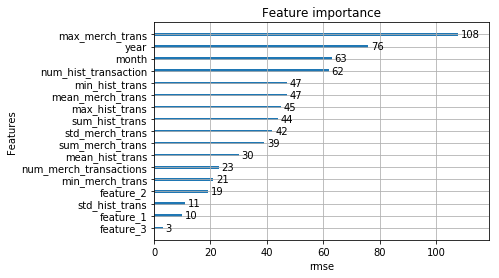

In [69]:
plt.figure(figsize=(12, 6))
plot_importance(model, xlabel='rmse')
plt.show()

In [70]:
sub_df = pd.DataFrame({"card_id":test_df["card_id"].values})
sub_df["target"] = pred
sub_df.to_csv("baseline_xgb.csv", index=False)

In [72]:
train_df.to_csv('new_train.csv', index=False)
test_df.to_csv('new_test.csv', index=False)

In [74]:
with open('use_to_col.txt', 'w') as fout:
    for i in cols_to_use:
        fout.write(i)
        fout.write(',')